# Sample 1 - RandomForest Classifer

## Step.1 データの読み込み
`utils.load_data`関数を使用し， 今回使用するデータの全てを読み込みます．

In [1]:
import utils

# Load CSV
X_raw, Y_raw, cols_raw = utils.load_data(mode="all")
print("len(X_raw)={}, X_raw[0]={}, Y_raw={}".format(len(X_raw), X_raw[0].shape, Y_raw.shape))

for i,key in enumerate(cols_raw):
    print("col_row[{}] = {}".format(i, key))

len(X_raw)=631, X_raw[0]=(9360, 8), Y_raw=(631, 1)
col_row[0] = lon
col_row[1] = lat
col_row[2] = azimus
col_row[3] = elevation
col_row[4] = daytime
col_row[5] = elapsed
col_row[6] = clock
col_row[7] = days


## Step.2 軌跡の時系列データに対して特徴抽出
+ 各タイムステップに対して，　特徴抽出を行います． サンプルでは 速度と加速度， およびその差分値を計算する関数を用意しました．
+ `utils.feature_extraction_broadcast`　関数に元データ(`X_raw`)と処理関数を渡します．　また計算に使用する列はcolsで指定します．
+ 抽出した特徴は, `utils.feature_concatenate`を使って，1つの変数に結合してください.

In [2]:
# Feature Extraction from whole trajectory
X_speed, cols_speed = utils.feature_extraction_broadcast(X_raw, func=utils.get_speed_and_acc, cols=[0,1,5,])
print("X_speed[0]={}\n".format(X_speed[0].shape))

for i,key in enumerate(cols_speed):
    print("col_speed[{}] = {}".format(i, key))

X_speed[0]=(9360, 4)

col_speed[0] = speed
col_speed[1] = speed_diff
col_speed[2] = acc
col_speed[3] = acc_diff


In [3]:
# Concatenate Extracted Feature Vectors
X = utils.feature_concatenate(X_raw, X_speed)

cols = cols_raw + cols_speed
print("len(X)={}, X[0]={}\n".format(len(X), X[0].shape))

for i,key in enumerate(cols):
    print("col{:>4} = {}".format(i, key))

len(X)=631, X[0]=(9360, 12)

col   0 = lon
col   1 = lat
col   2 = azimus
col   3 = elevation
col   4 = daytime
col   5 = elapsed
col   6 = clock
col   7 = days
col   8 = speed
col   9 = speed_diff
col  10 = acc
col  11 = acc_diff


## Step.3 軌跡全体から特徴抽出 (時系列を圧縮) & Training/Test Dataへ分割
+ 時間方向に圧縮を行い， 多次元の時系列データを1つの値に圧縮します.
+ configを編集することで行えます. 特徴量の名前(col_name), 抽出対象のカラムID(col), 特徴抽出に使用する関数(aggfunc).

In [15]:
import numpy as np

config  = [
    {"col_name":"lon_mean", "col":0,"aggfunc": np.mean, },
    {"col_name":"lon_std",     "col":0,"aggfunc": np.std },
    {"col_name":"lon_min",     "col":0,"aggfunc": np.min },
    {"col_name":"lon_max",     "col":0,"aggfunc": np.max },
    
    {"col_name":"lat_mean", "col":1,"aggfunc": np.mean, },
    {"col_name":"lat_std",     "col":1,"aggfunc": np.std },
    {"col_name":"lat_min",     "col":1,"aggfunc": np.min },
    {"col_name":"lat_max",     "col":1,"aggfunc": np.max },
    
        
    {"col_name":"speed_mean", "col":8,"aggfunc": np.mean, },
    {"col_name":"speed_std", "col":8,"aggfunc": np.std },
    #{"col_name":"speed_min", "col":8,"aggfunc": np.min },
    
    {"col_name":"acc_mean", "col":8,"aggfunc": np.mean, },
    {"col_name":"acc_std", "col":8,"aggfunc": np.std },
    
    {"col_name":"days", "col":7,"aggfunc": np.max },
]
df =  utils.feature_aggrigator(X, config,)


# Split Data
df, (X_train, Y_train), (X_test, Y_test) = utils.split_train_test(df, Y_raw, use_std=True)
print("X_train={}, Y_train={}".format(X_train.shape, Y_train.shape,))
print("X_test={}, Y_test={}".format(X_test.shape, Y_test.shape,))
display(df.head())

X_train=(500, 13), Y_train=(500,)
X_test=(131, 13), Y_test=(131,)


,lon_mean,lon_std,lon_min,lon_max,lat_mean,lat_std,lat_min,lat_max,speed_mean,speed_std,acc_mean,acc_std,days,true
0,0.485390,-0.191123,0.564601,0.333691,1.345543,1.167651,0.519580,1.303818,-0.545262,-0.252432,-0.545262,-0.252432,2.051088,1
1,-0.054167,-0.336685,0.234253,-0.266399,0.681712,0.362747,0.512368,0.467314,1.144472,0.993693,1.144472,0.993693,-0.209192,1
2,-0.292809,-0.605986,0.348983,-0.543969,-0.500866,-0.735253,0.495949,-0.636023,-1.591125,-1.818191,-1.591125,-1.818191,-0.661248,1
3,-0.015994,-0.567528,0.563563,-0.319971,-0.643078,-0.644308,0.346120,-0.613959,-0.173540,-0.886447,-0.173540,-0.886447,-0.661248,1
4,-0.543081,0.142169,-0.956317,-0.024320,1.072380,0.782345,0.522187,1.126764,-0.219898,0.203248,-0.219898,0.203248,1.599032,1


## Step.4 学習

In [16]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)


# Save Prediction Results
df_pred = df.loc[range(500,631), :].reset_index(drop=False).rename(columns={"index":"ID"})
df_pred["pred"] = Y_pred
display(df_pred.head())

,ID,lon_mean,lon_std,lon_min,lon_max,lat_mean,lat_std,lat_min,lat_max,speed_mean,speed_std,acc_mean,acc_std,days,true,pred
0,500,-0.988184,0.137444,-1.365229,-0.568244,-0.902806,-0.628657,-1.743436,-0.851630,2.156109,0.248237,2.156109,0.248237,-0.661248,1,1
1,501,-0.910996,0.104998,-0.909248,-0.568244,-0.781856,-0.659049,-0.605660,-0.764134,0.245357,0.799538,0.245357,0.799538,-0.661248,1,1
2,502,-0.040848,-0.529712,0.544701,-0.314949,-0.581893,-0.750476,0.510427,-0.663179,-0.337238,0.061653,-0.337238,0.061653,-0.661248,1,0
3,503,0.071525,-0.513551,0.528434,-0.265143,-0.422171,-0.674956,0.496725,-0.547119,-0.535585,0.176832,-0.535585,0.176832,-0.661248,1,1
4,504,-1.120915,0.619954,-1.802694,-0.421590,-0.799170,-0.448640,-1.308040,-0.646890,3.390169,0.946858,3.390169,0.946858,-0.661248,0,0


## Step.5 結果の確認

In [17]:
# スコアの確認
utils.scores(df_pred)

,Male,Female,All
Precision,0.806452,0.710145,0.755725
Recall,0.714286,0.803279,0.755725
F1,0.757576,0.753846,0.755725


2018-10-22 07:56:38,022 | INFO  | utils.draw_cmx | Start: Draw CMX


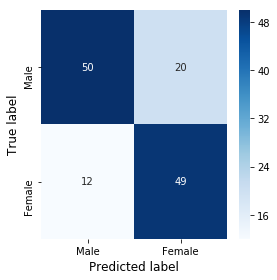

,Male,Female
Male,50,20
Female,12,49


In [18]:
import matplotlib
%matplotlib inline 

# Confution Matrix
utils.draw_cmx(df_pred)

# -----------------------------

# 結果の分析
ヒストグラムや散布図などを使って，　使用した特徴量が適切か確認します．

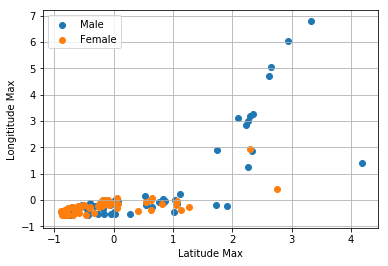

In [19]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

df_male    = df_pred[df_pred["true"] == 0]
df_female = df_pred[df_pred["true"] == 1]

plt.figure()
plt.scatter(df_male["lat_max"], df_male["lon_max"], label="Male")
plt.scatter(df_female["lat_max"], df_female["lon_max"], label="Female")
plt.xlabel("Latitude Max")
plt.ylabel("Longititude Max")
plt.grid()
plt.legend()
plt.show()

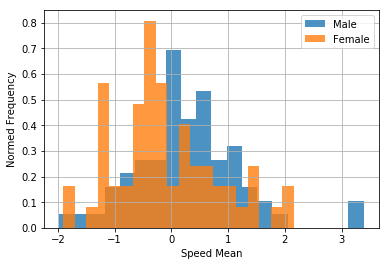

In [20]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

df_male    = df_pred[df_pred["true"] == 0]
df_female = df_pred[df_pred["true"] == 1]

plt.figure()
plt.hist(df_male["speed_mean"], density=True, bins=20, alpha=0.8, label="Male")
plt.hist(df_female["speed_mean"], density=True, bins=20, alpha=0.8,  label="Female")
plt.ylabel("Normed Frequency")
plt.xlabel("Speed Mean")
plt.grid()
plt.legend()
plt.show()